## Relevant imports

In [1]:
import pandas as pd

from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
%matplotlib inline

## Read and split data into a train and a valid set

In [2]:
# read original data from train.csv. This data set is taken from a real Kaggle competition (Santander-May 2016)
# (there is also a dedicated test set available, which was not taken into account here)
orig_data = pd.read_table('train.csv', sep=',', header=0)

# inspect the shape of the original data. It consists of 76020 rows (customers) and 371 attributes
print(orig_data.shape)

(76020, 371)


In [3]:
# separate label information from features and drop the ID as it is not relevant for future training purposes.
# according to the data description in the competition, the label's values are 0=satisfied and 1=unsatisified customer
labels = orig_data['TARGET']
features = orig_data.drop(['ID', 'TARGET'], axis=1)

print (labels.shape) # 76020 labels
print (features.shape) # 76020 customers described through 369 features (=attributes)

(76020,)
(76020, 369)


In [4]:
# split the original data set into an X_train and an X_valid set and respective labels Y_train and Y_valid.
# on the X_train set a classifier will be trained and on the X_valid set it will be applied for predictions. 

# stratfiedShuffleSplit used: to keep the ratio of 0s and 1s in your train and valid sets, so that not all 1s are 
# in the Y_train and only 0s are in Y_valid etc. So, keep the proportion of satisfied/unsatisfied customers in 
# both sets train and valid. 

# test_size=0.2: the valid set will have 20% and the train set 80% of the original data.

sfs = StratifiedShuffleSplit(labels, test_size=0.2)
for train_index, test_index in sfs:
    X_train, X_valid = features.iloc[train_index], features.iloc[test_index] #needs iloc to get indexes straight
    Y_train, Y_valid = labels[train_index], labels[test_index]
    
print (X_train.shape, ' ', Y_train.shape) # 60816 samples will be used to train a model - 80%
print (X_valid.shape, ' ', Y_valid.shape) # 15204 samples will be used to validate the model on unseen data - 20%

(60816, 369)   (60816,)
(15204, 369)   (15204,)


Now, a first classifier can be trained on the X_train set. 

It can then be used for a first prediction on X_valid. The predicted values will be compared to the Y_valid values. 

Leading to a first benchmark performance.

# Model train - Representation and a first prediction score

In [5]:
clf = RandomForestClassifier(n_estimators=10, class_weight='balanced')

# TRAIN
clf.fit(X_train, Y_train) 

 
# PREDICT       
pred_labels = clf.predict(X_valid)
pred_proba = clf.predict_proba(X_valid)[:,1]
    

# EVALUATE
pred_score = clf.score(X_valid, Y_valid)
print('... prediction score: {0:0.2f}%'.format(pred_score * 100))

... prediction score: 93.77%


My first prediction score ever, with a very very simple random forest classifier, resulting in a score of 95.42%! I was amazed. But after my first 5 minutes of triumph I started to disbelieve that this could be true. 

Did I do everything right? how does prediction score work? how does performance evaluation work? 
After browsing through some books and articles, I found the suggestion to check the balance (or imbalance) of your dataset!

In other words, in my train set, how many entries are labeled with 0 and how many with 1?

In [6]:
# let's have a look at the data's balance or imbalance
# in other words, analyze how many 'satisfied vs. unsatisfied' customers are in our original data set
df = pd.DataFrame(orig_data.TARGET.value_counts())
df.columns = ['Target']
df['perc'] = 100 * df['Target'] / orig_data.shape[0]    
    
print(df)
print('')
print('...{0:0.2f} satisfied customers vs. {1:0.2f} unsatisfied customer'.format(df.loc[0,'perc'], df.loc[1,'perc']))

   Target       perc
0   73012  96.043147
1    3008   3.956853

...96.04 satisfied customers vs. 3.96 unsatisfied customer


Now it cleared up. 96% of all samples result in 0 (satisified) and only 4% result in 1 (unsatisfied).

This means if I always predicted a 0 (satisfied customer), without even thinking or analyzing etc. just take 0 as default value, I would reach a prediction score of 96%! This is even better than my classifier.  

This is not really fulfilling the business purpose! 
The goal is to find the 4% unsatisfied customers. From a business perspective it might even be better, to find more than the relevant 4% to be sure that we didn't miss any unsatisfied customer. Not saying that it is good to predict satisfied customers as unsatisfied, but the other way around is even worse. 

So as a conclusion: 
- prediction score only should be taken with a grain of salt! 
- always check your data's balance (at least in a case as the one described here)
- check out other performance evaluations, as outlined below: confusion matrix and auc/roc curve

## Evaluate performance using confusion matrix and AUC / ROC

In [7]:
# first let's print the confusion matrix (true_labels, pred_labels), to understand what kind of errors the classifier 
# produces. Always enter the actual values first, followed by the predictions. 

print(confusion_matrix(Y_valid, pred_labels))

[[14204   398]
 [  549    53]]


The matrix above has to be read as following:

- Actual satisfied (0) and predicted satisfied (0) = 14484 (TN - true negative)
- Actual satisfied (0) and predicted unsatisfied (1) = 118 (FP - false positive)
- Actual unsatisfied (1) and predicted satisfied (0) = 575 (FN - false negative)
- Actual unsatisfied (1) and predicted unsatisfied (1) = 27 (TP - true positive)

The FP are not nice, but in the worst case I approach a satisfied customer again to try to make him satisfied. What really hurts from my point of view are the FN: People that have been predicted as satisfied, but are actually unsatisfied! 

Let's try another performance evaluator to see how well the classifier performs: the auc value and roc curve.

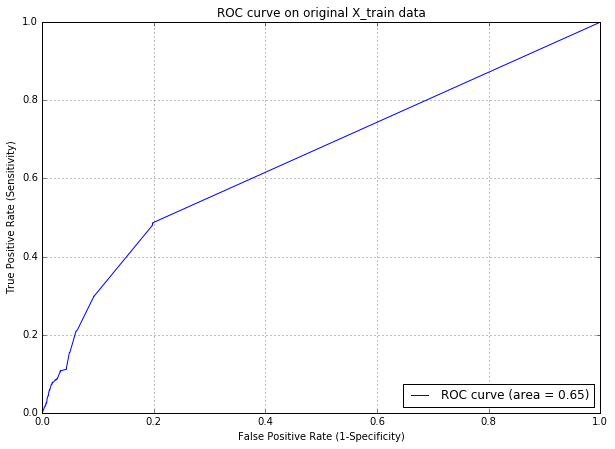

In [8]:
# calculate the false positive and true positive rates. 
# calculate the auc score

fpr, tpr, thresholds = roc_curve(Y_valid, pred_proba)
auc_score = roc_auc_score(Y_valid, pred_proba) 


# plot the roc curve
fig = plt.figure(figsize=(10,7))
fig.add_subplot(1,1,1)    
    
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(auc_score))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve on original X_train data')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend(loc='lower right')
print('')

Is this good or bad? Well according to auc which is represented by the value (area=0.69), this is poor.

auc values:
- 0.9 - 1.0 = excellent
- 0.8 - 0.9 = good
- 0.7 - 0.8 = fair
- 0.6 - 0.7 = poor
- 0.5 - 0.6 = failed

This can also be seen by the roc curve which is 'quite flat'. The optimal curve (e.g. an excellent classifier's roc curve) would hit the upper left corner. 

So much for my first steps and lessons learnt. Next steps will follow: how does this roc curve have to be interpreted? how can I bring my FN down? ... 